In [16]:
library(tidyverse)
library(tidymodels)
library(repr)
options(repr.matrix.max.rows = 6)
install.packages('kknn')
library("kknn")
url <- "https://raw.githubusercontent.com/Xela-debug/datasets/main/Housing.csv"
housing_df <- read_csv(url)
set.seed(2023)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Rows: 545 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (7): mainroad, guestroom, basement, hotwaterheating, airconditioning, pr...
dbl (6): price, area, bedrooms, bathrooms, stories, parking

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [18]:
housing_df

price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>
13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
1750000,3620,2,1,1,yes,no,no,no,no,0,no,unfurnished
1750000,2910,3,1,1,no,no,no,no,no,0,no,furnished
1750000,3850,3,1,2,yes,no,no,no,no,0,no,unfurnished


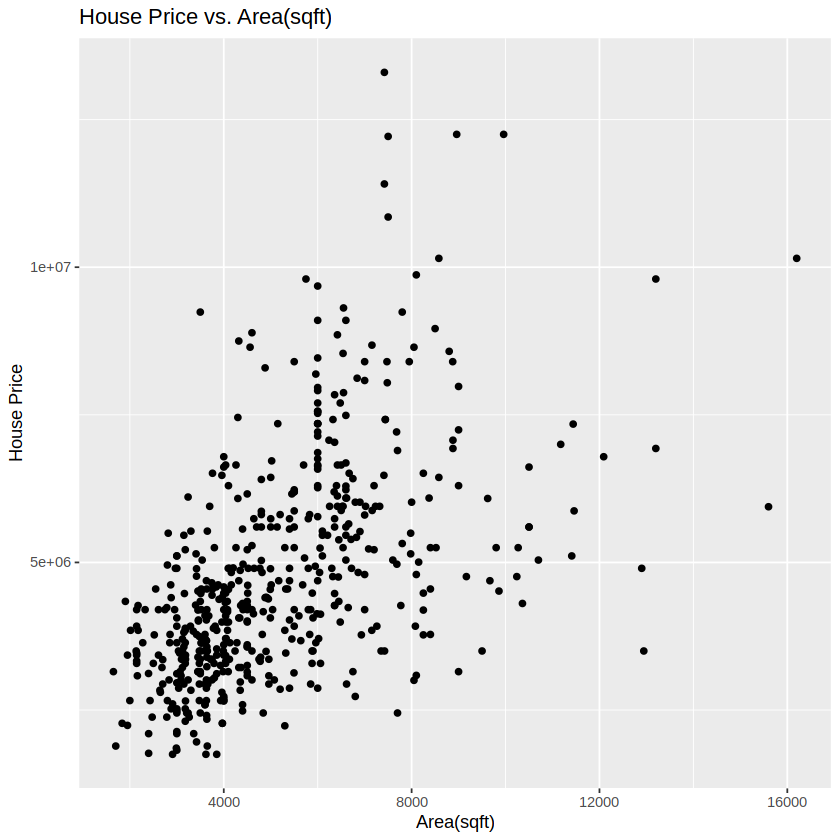

In [40]:
housing_plot <- housing_df|>
    ggplot(aes(x = area, y = price))+
    geom_point()+
    labs(x = "Area(sqft)", y = "House Price")+
    ggtitle("House Price vs. Area(sqft)")
housing_plot

**KNN Regression Model**

In [41]:
set.seed(2023)
housing_split <- initial_split(housing_df, prop = 0.75, strata = price)
housing_test <- testing(housing_split)
housing_train <- training(housing_split)

In [42]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("regression")

knn_recipe <- recipe(price ~ area, 
                     data = housing_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

knn_vfold <- vfold_cv(housing_train, v = 5, strata = price)

gridvals <- tibble(neighbors = seq(1, 10))

knn_fit <- workflow() |>
    add_recipe(knn_recipe) |>
    add_model(knn_spec)

knn_results <- knn_fit |>
    tune_grid(resamples = knn_vfold, grid = gridvals) |>
    collect_metrics()

knn_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,2.149598e+06,5,1.083070e+05,Preprocessor1_Model01
1,rsq,standard,1.379220e-01,5,5.616537e-02,Preprocessor1_Model01
2,rmse,standard,1.816463e+06,5,6.998185e+04,Preprocessor1_Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
9,rsq,standard,3.402485e-01,5,2.218401e-02,Preprocessor1_Model09
10,rmse,standard,1.539488e+06,5,7.625714e+04,Preprocessor1_Model10
10,rsq,standard,3.359360e-01,5,1.941255e-02,Preprocessor1_Model10


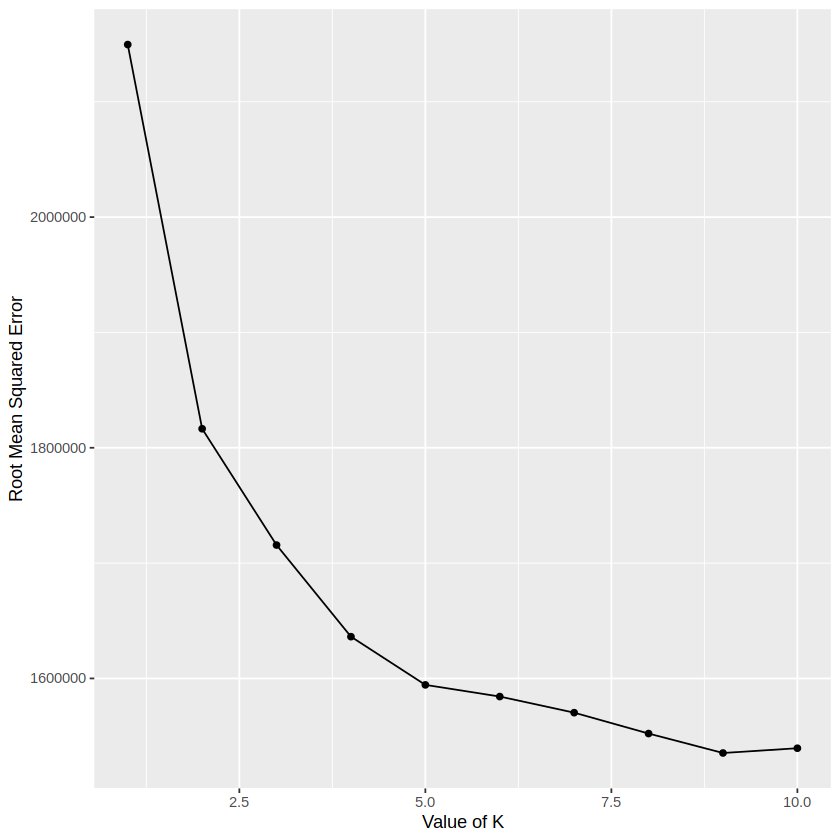

In [43]:
knn_plot <- knn_results |>
    filter(.metric == "rmse") |>
    select(neighbors, .metric, mean) |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_line() +
    geom_point() +
    labs(x = "Value of K", y = "Root Mean Squared Error")

knn_plot

RMSE drops to a low at a K-value of 8, but it actually is quite close to the minimum at a K-value of 5. Regardless, a K of 8 will be used as there are sufficient data points in the set to not risk problems.

In [44]:
# Checking one more time for lowest RMSE
knn_min <- knn_results |>
   filter(.metric == "rmse") |>
   slice_min(mean, n = 1) |>
   pull(neighbors)

knn_min

[1] 9

In [45]:
knn_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = knn_min) |>
    set_engine("kknn") |>
    set_mode("regression")

knn_best_fit <- workflow() |>
    add_recipe(knn_recipe) |>
    add_model(knn_best_spec) |>
    fit(data = housing_train)

knn_summary <- knn_best_fit |>
    predict(housing_test) |>
    bind_cols(housing_test) |>
    metrics(truth = price, estimate = .pred)

knn_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,1.539679e+06
rsq,standard,3.580813e-01
mae,standard,1.092089e+06


**Linear Regression Model**

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
(Intercept)         area  
  2310714.0        478.9  



.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,4948125
rsq,standard,1
mae,standard,4830219


[1] 56.14679

[1] 43.85321

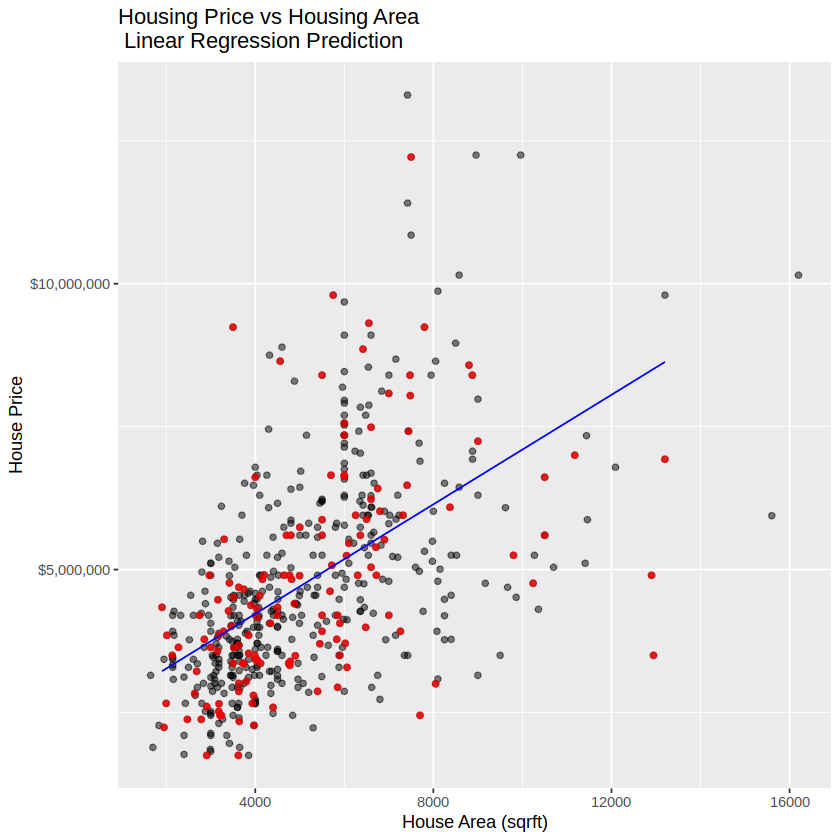

In [48]:
set.seed(2023)
lm_spec <- linear_reg() |>
    set_engine("lm") |>
    set_mode("regression")

housing_recipe <- recipe(price ~ area, data = housing_train)

housing_fit <- workflow() |>
    add_recipe(housing_recipe) |>
    add_model(lm_spec) |>
    fit(data = housing_train)
print(housing_fit)

lm_results <- housing_fit |>
    predict(housing_test) |>
    bind_cols(housing_test) |>
    metrics(truth = area, estimate = .pred)
lm_results

housing_preds <- housing_fit |>
    predict(housing_test) |>
    bind_cols(housing_test)

housing_result_plot <- housing_df |>
    ggplot(aes(x = area, y = price)) +
        geom_point(alpha = 0.5) +
        geom_point(data = housing_test,
                  colour = "red",
                  alpha = 0.7) +
        geom_line(data = housing_preds,
                 mapping = aes(x = area, y = .pred),
                 colour = "blue") +
        labs(x = "House Area (sqrft)", y = "House Price", title = "Housing Price vs Housing Area \n Linear Regression Prediction") +
        scale_y_continuous(labels = dollar_format())
housing_result_plot

housing_preds <- housing_fit |>
    predict(housing_df) |>
    bind_cols(housing_df)

housing_cheap <- housing_preds |>
    filter(price < .pred)
percentage_of_cheaper_homes <- nrow(housing_cheap) / nrow(housing_df) * 100
percentage_of_cheaper_homes

housing_expensive <- housing_preds |>
    filter(price > .pred)
percentage_of_more_expensive_homes <- nrow(housing_expensive) / nrow(housing_df) * 100
percentage_of_more_expensive_homes

**Comparison**

After comparing the rmspe of both the linear and knn regression model, we can conclude that a linear regression model provide higher accuracy for predicting the housing price, since it demonstrates lower rmspe. 